# Ejercicio 1
***
***

In [1]:
import sys
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
SPARK_MASTER_HOST = "spark-master"
SPARK_MASTER_PORT = 7077

In [3]:
sys.version

'3.6.15 (default, Feb  7 2024, 02:37:02) \n[GCC 10.2.1 20210110]'

In [4]:
pyspark.__version__

'2.3.0'

In [5]:
spark = SparkSession.builder  \
    .appName("GrandataEj1")  \
    .master(f"spark://{SPARK_MASTER_HOST}:{SPARK_MASTER_PORT}")  \
    .getOrCreate()

In [6]:
spark

In [7]:
REGIONS = [i for i in range(1,10)]
LOW_SMS_RATE_REGIONS = [i for i in range(1,6)]
LOW_SMS_RATE = 1.5
HIGH_SMS_RATE = 2

***
***
## Analisis Exploratorio
***

In [8]:
# Leo datasets
path = "./datasets/events.csv.gz"
df_events = spark.read.csv(path=path, header=True)

path = "./datasets/free_sms_destinations.csv.gz"
df_free = spark.read.csv(path=path, header=True)

In [9]:
df_events.show()
df_events.printSchema()
print(f"Shape: {df_events.count()}, {len(df_events.columns)}")

+----+-----+-------+---+--------+------+---------+--------------+
|hour|calls|seconds|sms|    date|region|id_source|id_destination|
+----+-----+-------+---+--------+------+---------+--------------+
|  11|    1|     24|  0|20211001|     5|      BF3|           374|
|   1|    1|     51|  0|20211001|     4|      9F5|           374|
|  11|    1|      3|  0|20211001|     6|      025|           374|
|  10|    1|     36|  0|20211001|     5|      FB6|           D52|
|  23|    4|    137|  0|20211001|     8|      4BB|           861|
|  18|    0|      0|  1|20211001|     4|      90C|           5B0|
|  13|    1|    618|  0|20211001|     9|      7AB|           4CA|
|  16|    1|    172|  0|20211001|     9|      7AB|           4CA|
|   6|    1|    208|  0|20211001|     9|      7AB|           4CA|
|   5|    1|     66|  0|20211001|     9|      7AB|           4CA|
|  18|    1|    135|  0|20211001|     9|      7AB|           4CA|
|  12|    0|      0|  8|20211001|     9|      0A4|           465|
|  21|    

In [10]:
# Exploracion de Nulos
df_events.select([F.count(F.when(F.isnull(col), col)).alias(col) for col in df_events.columns]).show()

# Exploracion de NaNs
df_events.select([F.count(F.when(F.isnan(col), col)).alias(col) for col in df_events.columns]).show()

+----+-----+-------+---+----+------+---------+--------------+
|hour|calls|seconds|sms|date|region|id_source|id_destination|
+----+-----+-------+---+----+------+---------+--------------+
|   0|    0|      0|  0|   0|     0|       18|            15|
+----+-----+-------+---+----+------+---------+--------------+

+----+-----+-------+---+----+------+---------+--------------+
|hour|calls|seconds|sms|date|region|id_source|id_destination|
+----+-----+-------+---+----+------+---------+--------------+
|   0|    0|      0|  0|   0|     0|        0|             0|
+----+-----+-------+---+----+------+---------+--------------+



In [11]:
# Verifico si hay registros fuera de las 9 regiones para las que tengo tarifa
df_events.filter(~F.col("region").isin(REGIONS)).count()

0

***

In [12]:
df_free.show()
df_free.printSchema()
print(f"Shape: {df_free.count()}, {len(df_free.columns)}")

+---+
| id|
+---+
|374|
|D52|
|861|
|5B0|
|4CA|
|465|
|048|
|D5B|
|FD6|
|2D3|
|B3F|
|6AF|
|216|
|C3A|
|EE2|
|328|
|99E|
|BF6|
|60F|
|6AC|
+---+
only showing top 20 rows

root
 |-- id: string (nullable = true)

Shape: 200, 1


In [13]:
# Exploracion de Nulls
df_free.select([F.count(F.when(F.isnull(col), col)).alias(col) for col in df_free.columns]).show()

# Exploracion de NaNs
df_free.select([F.count(F.when(F.isnan(col), col)).alias(col) for col in df_free.columns]).show()

+---+
| id|
+---+
|  0|
+---+

+---+
| id|
+---+
|  0|
+---+



***
***
## Inciso 1
**_Calcular el monto total que facturará el proveedor del servicio por envíos de sms._**
***

**Descartamos registros con id_source o id_destination nulo.**

**Descartamos registros sin SMS para filtrar lo más posible los datos antes del join.**

**Hacemos un join "left_anti" (notar que es análogo a un "left outer" seguido de un a selección de las columnas con id Null).**

**Agregamos columna con la tarifa de SMS según región (notar que como sé que no hay registros con regiones fuera de las tarifadas, puedo hacer una evaluación binaria).**

In [14]:
df_events = df_events.dropna(subset=["id_source", "id_destination"])
#df_events.persist()

df_sms = df_events.filter(F.col("sms") != 0) \
                  .join(df_free, on=[df_events.id_destination == df_free.id], how='left_anti') \
                  .withColumn("rate_sms", F.when(df_events.region.isin(LOW_SMS_RATE_REGIONS), LOW_SMS_RATE) \
                              .otherwise(HIGH_SMS_RATE))

**Agregamos columna con facturación total por SMS por registro y agrego para obtener el resultado buscado...**

In [15]:
df_sms = df_sms.withColumn("sms_hour_billing", df_sms.rate_sms*df_sms.sms)
df_sms.select(F.sum(df_sms.sms_hour_billing).alias("sms_total_billing")).show()

+-----------------+
|sms_total_billing|
+-----------------+
|         391367.0|
+-----------------+



***
***
## Inciso 2
**_Generar un dataset que contenga los ID de los 100 usuarios con mayor facturación por envío de sms y el monto total a facturar a cada uno. Además del ID, incluir el ID hasheado mediante el algoritmo MD5. Escribir el dataset en formato parquet con compresión gzip._**
***

**Agregamos facturación horaria por SMS agrupango por ID de usuario de origen.**

**Nos quedamos con los 100 de mayor facturación y agrego una columna hasheando el ID.**

In [17]:
df_unload = df_sms.groupBy("id_source").agg(F.sum("sms_hour_billing").alias("user_sms_total_billing"))\
                                       .orderBy(F.col("user_sms_total_billing").desc()).limit(100) \
                                       .withColumn("id_source_md5", F.md5(df_sms.id_source))


df_unload.show(truncate=False)
#df_unload.coalesce(1).write.parquet(path="top100billings.parquet", compression="gzip")

+---------+----------------------+--------------------------------+
|id_source|user_sms_total_billing|id_source_md5                   |
+---------+----------------------+--------------------------------+
|4D3      |23403.0               |911914c7729eedbdf5b0f03159f451a9|
|76D      |13664.0               |bd180b7811395cbce5076b52a78ca50d|
|07E      |4226.0                |14a0660ae2f5d186882df86c2972fa93|
|541      |2526.0                |16c222aa19898e5058938167c8ab6c57|
|C25      |2019.0                |0bfa0b57d99985aa138ce05055a3c5db|
|17D      |1209.0                |7521526054bb89ba243073f7e5e541ec|
|3AE      |1087.5                |6a57072949dbc409cc48ef7bd8b05335|
|B86      |1054.5                |bc97b32ee2abb9c18aad55b9da9f51c0|
|E89      |979.5                 |5135cc35322269f2fb397b4f81426938|
|B71      |972.0                 |1088a10d026eae0ac20f59f5249db2ea|
|162      |887.5                 |82aa4b0af34c2313a562076992e50aa3|
|068      |854.5                 |fb8490a9504a36

***
***
## Inciso 3
**_Graficar un histograma de cantidad de llamadas que se realizan por hora del día._**
***

In [18]:
plt.style.use('seaborn-deep')

**Hacemos el reduce de los datos en spark para mandar small data a las funciones de graficado...**

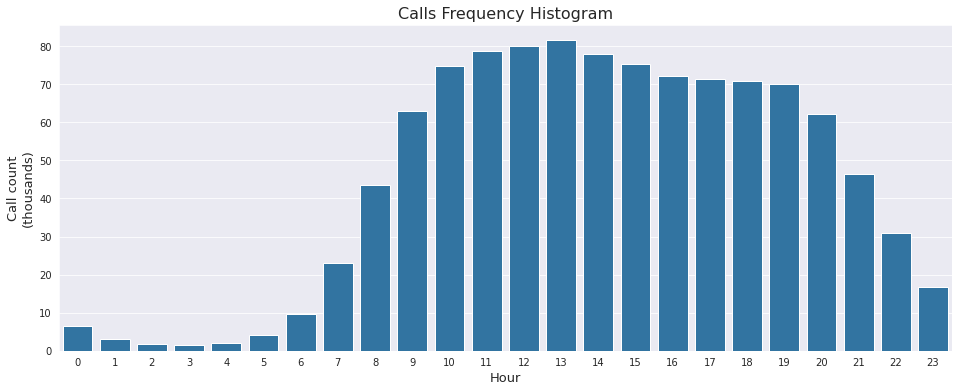

In [19]:
df_hist = df_events.groupBy("hour").agg(F.sum("calls").alias("hour_total_calls")) \
                   .withColumn("hour", F.col("hour").cast("integer")) \
                   .orderBy(F.col("hour"))

hours, calls = [], []
for row in df_hist.collect():
    hours.append(row.hour)
    calls.append(row.hour_total_calls/1000)
    
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(1,1,figsize=(16,6))
    sns.barplot(x=hours, y=calls, color="tab:blue", ci=None, ax=ax)
    ax.set_xlabel("Hour", fontsize=13)
    ax.set_ylabel("Call count\n(thousands)", fontsize=13)
    ax.set_title("Calls Frequency Histogram", fontsize=16)
    #fig.savefig("histogram1.png")

**Como bonus track generamos otro histograma discriminando por tarifa...**

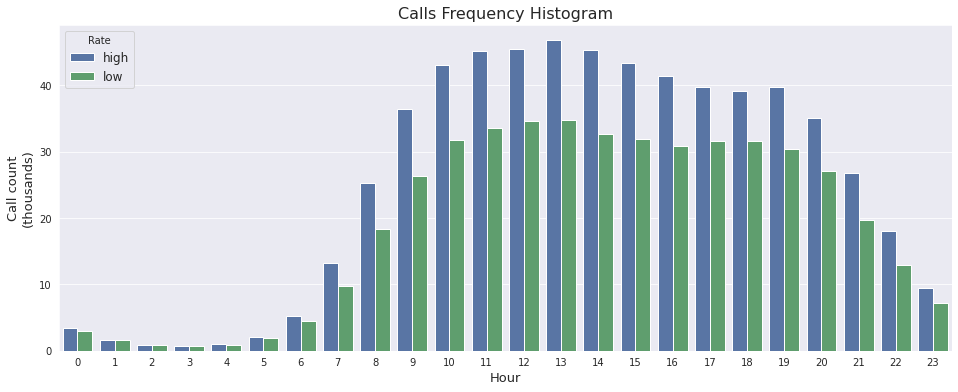

In [20]:
df_hist = df_events.withColumn("rate_sms", F.when(df_events.region.isin(LOW_SMS_RATE_REGIONS), "low").otherwise("high")) \
                   .groupBy(["hour", "rate_sms"]).agg(F.sum("calls").alias("hour_total_calls")) \
                   .withColumn("hour", F.col("hour").cast("integer")) \
                   .orderBy(F.col("hour"))

hours, calls, rate = [], [], []
for row in df_hist.collect():
    hours.append(row.hour)
    calls.append(row.hour_total_calls/1000)
    rate.append(row.rate_sms)
    
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(1,1,figsize=(16,6))
    sns.barplot(x=hours, y=calls, hue=rate, ci=None, ax=ax)
    ax.set_xlabel("Hour", fontsize=13)
    ax.set_ylabel("Call count\n(thousands)", fontsize=13)
    ax.set_title("Calls Frequency Histogram", fontsize=16)
    ax.legend(fontsize=12, title="Rate", loc=2)
    #fig.savefig("histogram2.png")

In [21]:
spark.stop()

***
***